# Build a model predicting Drug Induced Liver Injury

**Dataset Description:**
Drug-induced liver injury (DILI) is fatal liver disease caused by drugs and it has been the single most frequent cause of safety-related drug marketing withdrawals for the past 50 years (e.g. iproniazid, ticrynafen, benoxaprofen). This dataset is aggregated from U.S. FDA’s National Center for Toxicological Research.

**Task Description:**
Binary classification. Given a drug SMILES string, predict whether it can cause liver injury (1) or not (0).

## Dependencies

Before you run this notebook you must first install the dependencies using the dependencies.ipynb notebook.

Only needs to be done once, but if you start a new Jupyter instance then you will have to load them again

## Execution

In [23]:
from jaqpotpy import Jaqpot
from tdc.single_pred import Tox

In [1]:
data = Tox(name = 'DILI')
split = data.get_split()
split['train']
split['test']

train_smiles = split['train']['Drug']
train_labels = split['train']['Y']
test_smiles = split['test']['Drug']
test_labels = split['test']['Y']

Downloading...
100%|██████████| 26.7k/26.7k [00:00<00:00, 697kiB/s]
Loading...
Done!


Molecule prediction class : 0.0
Smiles of the molecule
O=c1[nH]c2ccccc2n1C1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1
Actual molecule


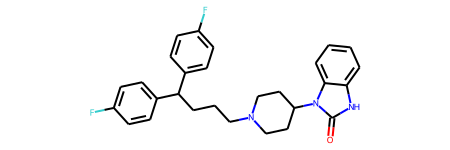

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

index = 204

print("Molecule prediction class : "  + str(train_labels[index]))
print("Smiles of the molecule")
print(train_smiles[index])
print("Actual molecule")
mol = Chem.MolFromSmiles(train_smiles[index])
mol

In [3]:
from jaqpotpy.datasets import SmilesDataset
from jaqpotpy.descriptors.molecular import TopologicalFingerprint


featurizer = TopologicalFingerprint()
train_dataset = SmilesDataset(smiles=train_smiles, y=train_labels, task = "classification", featurizer=featurizer)
test_dataset = SmilesDataset(smiles=test_smiles, y=test_labels, task = "classification", featurizer=featurizer)
train_dataset.create()
test_dataset.create()

Creating descriptors: 100%|██████████| 95/95 [00:00<00:00, 602.20it/s]


SmilesDataset

In [4]:
train_dataset.df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f2039,f2040,f2041,f2042,f2043,f2044,f2045,f2046,f2047,Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
328,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
330,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from jaqpotpy.models import Evaluator, MolecularTorchGeometric
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef\
    , precision_score, recall_score, confusion_matrix


val = Evaluator()
val.dataset = test_dataset

val.register_scoring_function('Accuracy', accuracy_score)
val.register_scoring_function('Binary f1', f1_score)
val.register_scoring_function('Roc Auc', roc_auc_score)
val.register_scoring_function("MCC", matthews_corrcoef)
val.register_scoring_function("Precision", precision_score)
val.register_scoring_function("Recall", recall_score)
val.register_scoring_function("Confusion Matrix", confusion_matrix)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from jaqpotpy.doa.doa import Leverage
from jaqpotpy.models import MolecularSKLearn

model = GradientBoostingClassifier(n_estimators=80, learning_rate=1.0, max_depth=1, random_state=0)
molecular_dili_model = MolecularSKLearn(dataset=train_dataset, doa=Leverage(), model=model, eval=val).fit()

Accuracy: 0.7368421052631579
Binary f1: 0.7368421052631579
Roc Auc: 0.7369237588652483
MCC: 0.47384751773049644
Precision: 0.7446808510638298
Recall: 0.7291666666666666
Confusion Matrix: [[35 12]
 [13 35]]


In [7]:
model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.2, max_depth=4, random_state=0)
molecular_dili_model = MolecularSKLearn(dataset=train_dataset, doa=Leverage(), model=model, eval=val).fit()

Accuracy: 0.8315789473684211
Binary f1: 0.8333333333333334
Roc Auc: 0.8315602836879433
MCC: 0.6631205673758865
Precision: 0.8333333333333334
Recall: 0.8333333333333334
Confusion Matrix: [[39  8]
 [ 8 40]]


In [8]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=20, random_state=1)
clf3 = GaussianNB()
clf4 = SVC(probability=True)
clf5 = GradientBoostingClassifier(n_estimators=30, learning_rate=0.2, max_depth=4, random_state=0)
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('gbc', clf5), ('svm', clf4)], voting='hard')


molecular_voting_dili_model = MolecularSKLearn(dataset=train_dataset, doa=Leverage(), model=eclf1, eval=val).fit()

Accuracy: 0.7789473684210526
Binary f1: 0.7835051546391752
Roc Auc: 0.7788120567375886
MCC: 0.5578714517501369
Precision: 0.7755102040816326
Recall: 0.7916666666666666
Confusion Matrix: [[36 11]
 [10 38]]


In [9]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=1)
clf2 = SVC(kernel="rbf", probability=True)
clf3 = GradientBoostingClassifier(n_estimators=30, learning_rate=0.2, max_depth=4, random_state=0)
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('gbc', clf2), ('svm', clf3),], voting='soft')


molecular_voting_dili_model = MolecularSKLearn(dataset=train_dataset, doa=Leverage(), model=eclf1, eval=val).fit()

Accuracy: 0.8210526315789474
Binary f1: 0.8247422680412372
Roc Auc: 0.8209219858156029
MCC: 0.6421286662434007
Precision: 0.8163265306122449
Recall: 0.8333333333333334
Confusion Matrix: [[38  9]
 [ 8 40]]


In [10]:
molecular_dili_model.model_title = "DILI_INJURY"

In [11]:
molecular_dili_model("O1C=C[C@H]([C@H]1O2)c3c2cc(OC)c4c3OC(=O)C5=C4CCC(=O)5")

Creating descriptors: 100%|██████████| 1/1 [00:00<00:00, 315.31it/s]


In [12]:
molecular_dili_model.doa.IN

[True]

In [13]:
print("The prediction of " + molecular_dili_model.model_title + " model is: " + str(molecular_dili_model.prediction))

The prediction of DILI_INJURY model is: [1.0]


In [14]:
mols = ['O=C1CCCN1Cc1cccc(C(=O)N2CCC(C3CCNC3)CC2)c1'
        , 'O=C1CCc2cc(C(=O)N3CCC(C4CCNC4)CC3)ccc2N1'
        , 'CCC(=O)Nc1ccc(N(Cc2ccccc2)C(=O)n2nnc3ccccc32)cc1'
        , 'COc1ccc2c(N)nn(C(=O)Cc3cccc(Cl)c3)c2c1'
        , 'Cc1nn(C)c2[nH]nc(NC(=O)Cc3cccc(Cl)c3)c12'
        , 'O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)c1cccc(Cl)c1'
        , 'COc1ccc(N(Cc2ccccc2)C(=O)Cc2c[nH]c3ccccc23)cc1'
        , 'CC(C)(C)c1ccc(N(C(=O)c2ccco2)[C@H](C(=O)NCCc2cccc(F)c2)c2cccnc2)cc1'
        , 'OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H]2[C@@H]1c3c(O)c(OC)c(O)cc3C(=O)O2'
        , 'Cc1ccncc1NC(=O)Cc1cc(Cl)cc(-c2cnn(C)c2C(F)F)c1'
        , 'Cc1cc(C(F)(F)F)nc2c1c(N)nn2C(=O)Cc1cccc(Cl)c1'
        , 'Cc1cc(C(F)(F)F)nc2c1c(N)nn2C(=O)C1CCOc2ccc(Cl)cc21'
        , 'O=C(c1cc(=O)[nH]c2ccccc12)N1CCN(c2cccc(Cl)c2)C(=O)C1'
        , 'O=C1NC2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12'
        , 'COCCNC(=O)[C@@H](c1ccccc1)N1Cc2ccccc2C1=O'
        , 'CNCC1CCCN(C(=O)[C@@H](c2ccccc2)N2Cc3ccccc3C2=O)C1'
        , 'O=C1NC2(CCOc3ccc(Cl)cc32)C(=O)N1c1cncc2ccccc12'
        , 'COc1ccc2c(NC(=O)C3CCOc4ccc(Cl)cc43)[nH]nc2c1'
        , 'O=C(NC1N=Nc2ccccc21)C1CCOc2ccc(Cl)cc21'
        , 'COc1ccccc1OC1CCN(C(=O)c2cc(=O)[nH]c3ccccc23)C1'
        , 'O=C(Cc1cc(Cl)cc(Cc2ccn[nH]2)c1)Nc1cncc2ccccc12'
        , 'CN(C)c1ccc(N(Cc2ccsc2)C(=O)Cc2cncc3ccccc23)cc1'
        , 'C[C@H]1COc2ccc(Cl)cc2[C@@H]1C(=O)Nc1cncc2ccccc12'
]

molecular_dili_model(mols)
print(molecular_dili_model.doa.IN)
print(molecular_dili_model.probability)
molecular_dili_model.prediction

Creating descriptors: 100%|██████████| 23/23 [00:00<00:00, 584.42it/s]


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
[[0.34626654539549806, 0.6537334546045019], [0.35931400091355425, 0.6406859990864457], [0.2465842732034298, 0.7534157267965702], [0.08842737292895908, 0.9115726270710409], [0.2840843788448626, 0.7159156211551374], [0.37168390270624907, 0.6283160972937509], [0.18424009939903763, 0.8157599006009624], [0.34255887046473155, 0.6574411295352685], [0.6898797516288906, 0.31012024837110946], [0.09323876443805701, 0.906761235561943], [0.23454455370512473, 0.7654554462948753], [0.7239384484192594, 0.27606155158074064], [0.09263513892122599, 0.907364861078774], [0.8139999231696171, 0.18600007683038292], [0.5900553764714271, 0.40994462352857286], [0.7890435509991828, 0.21095644900081723], [0.8139999231696171, 0.18600007683038292], [0.4140372436012285, 0.5859627563987715], [0.5325915262782785, 0.4674084737217215], [0.09325365980376665, 0.9067463401962333], [0.070

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
# Create the Jaqpot instance and prompt for the API key
a = input()
jaqpot = Jaqpot()
jaqpot.set_api_key(a)
# TODO - Jaqpot prints the key which is a security risk. Avoid doing this.

In [25]:
molecular_dili_model.Y = "DILI_INJURY"
molecular_dili_model.deploy_on_jaqpot(jaqpot=jaqpot, description = "DILI model from Squonk", model_title="DILI Injury from Squonk")

100%|██████████| 27/27 [00:46<00:00,  1.72s/it]
  2022-08-22 09:57:53,751 - INFO - Model with id: 3S80WgQD4YLkCExLQQpx created. Please visit the application to proceed
